# Study

You will have to solve 3 Tasks during this study. Each task is comprised of one probabilistic program that may or may not have errors. You have to figure out if there are issues with the program at hand, and if so, solve them. The tasks are to be done sequentially and you cannot jump between tasks. When you believe you have solved the task, please confirm it verbally and move on the next task. You will not receive feedback on your solutions while the study is in progress.

# PYMC 
This notebook assumes previous experience with any probabilistic programming language and sand serves as a quick overview of PYMC.
In addition to this notebook you can use any resource you require. 

For your convenience we link to certain parts of the PYMC documentation that might be helpful:
- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Prior and Posterior Predictive Checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)

In [1]:
import pymc as pm 
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## Modeling

Below we have implemented the classical coin flip model.
Given observed coin flips, we want to infer whether the coin is fair.
Thus, we put a Beta prior on the probability of flipping heads `p_heads` and represent the coin flips with a sample from `Bernoulli(p_heads)`.
We pass the observed coin flips as function argument and provide them with the observed keyword.

In [2]:
flips_obs = np.array([0.,1.,1.,0.,0.,1.,0.,1.,1.])

coinf_flip = pm.Model()

with coinf_flip:
	p_heads = pm.Beta('p_heads', alpha=1, beta=1)
	y = pm.Bernoulli('y', p=p_heads, observed=flips_obs)

`coinf_flip = pm.Model()` creates a new `Model`. We can use this model as a container with a `with coinf_flip:` statement to specify its components. 


A latent random variable can be created with following form: `RV = pm.DISTRIBUTION_TYPE('VAR_NAME', ...DIST_ARGS)`. 

In our model above we used this to model our coins bias as a latent random variable: `p_heads = pm.Beta('p_heads', alpha=1, beta=1)`.


Furthermore, we can model observed random variables with following form: `RV = pm.DISTRIBUTION_TYPE('VAR_NAME', ...DIST_ARGS, observed=OBSERVATIONS)`. 

In our model we used this to describe the outcome of a coinflip: `y = pm.Bernoulli('y', p=p_heads, observed=flips_obs)`. 


**NOTE:** `y` automatically has the dimensionality (9,) since we have 9 observations. So y are actually 9 iid (independent and identically distributed) random variables. We could model 9 separate variables by hand, but then we would lose performance since PYMC would no longer be able to use vectorization in the background.

## Inference

To perform inference on our model we have to use the model context again and call `pm.sample`:

In [3]:
with coinf_flip:
	idata = pm.sample(1000, tune=500)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.


PYMC uses NUTS as it's default sampler. To change the sampler you can create a sampler of your choice and set the step parameter of the `pm.sample`function. For example you could use HMC like that:

In [4]:
with coinf_flip:
	step = pm.HamiltonianMC(step_scale=0.5)
	idata = pm.sample(1000, tune=500, step=step)

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [p_heads]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


## Plots and Posterior Analysis

PYMC produces an ArviZ compatible trace object by default. ArviZ is a powerful library for exploratory analysis of Bayesian models. This section shows you non exhaustive examples of how you can use the ArviZ library for posterior analysis. Further details and examples can be found at: [ArviZ](https://python.arviz.org/en/stable/index.html) and their [Example Gallery](https://python.arviz.org/en/stable/examples/index.html).

### Summary

In [5]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [6]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_heads,0.54,0.15,0.28,0.81,0.0,0.0,3218.35,2628.66,1.0


### Trace Plots

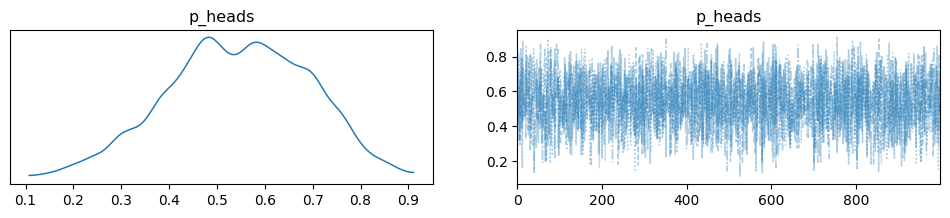

In [7]:
az.plot_trace(idata, var_names=["p_heads"], combined=True);

### Effective Sample Size (ESS)

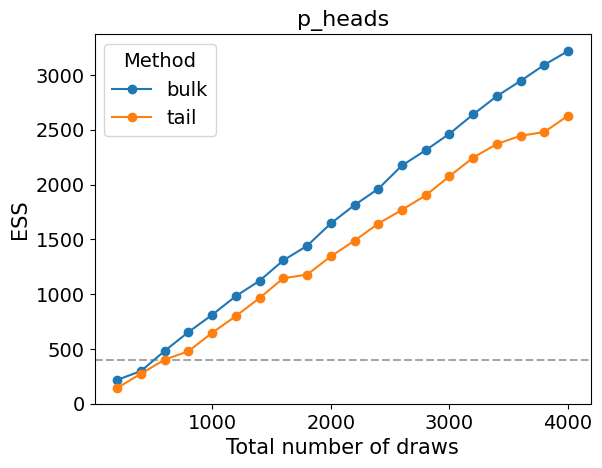

In [8]:
az.plot_ess(idata, kind="evolution");

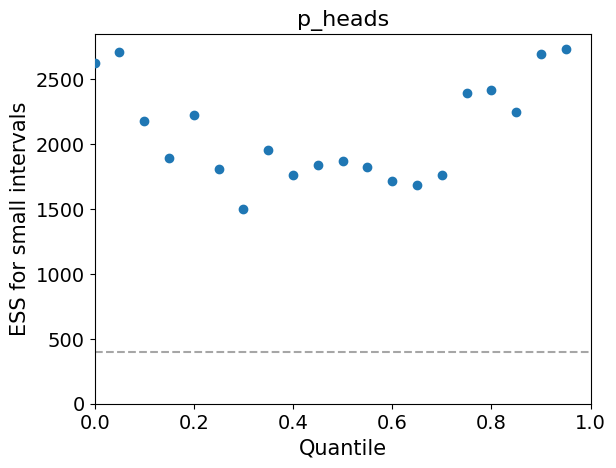

In [9]:
az.plot_ess(idata, kind="local");

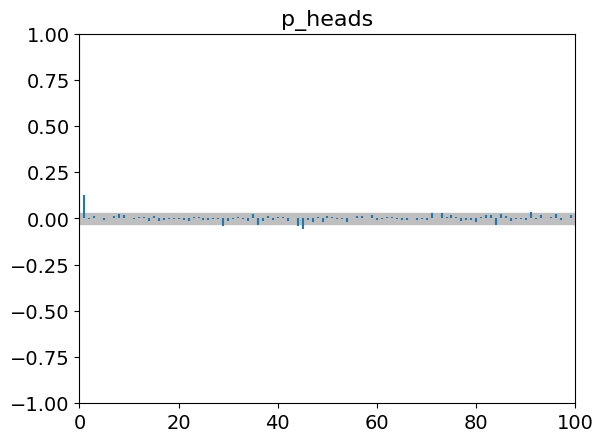

In [10]:
az.plot_autocorr(idata, combined=True);

### Pair Plots

Let's look at a hierarchical model:

In [11]:
import pytensor as pt

neals_funnel = pm.Model()

with neals_funnel:
	z = pm.Normal('z', mu=1, sigma=3)
	x = pm.Normal('x', mu=0, sigma=pt.tensor.exp(z/2))

with neals_funnel:
	idata = pm.sample(1000, tune=500)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, x]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
There were 704 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


With this type of model we often want to look at the parent -> child relationship. We can do so in different ways. Here we show examples of a scatterplot and a kernel density plot.

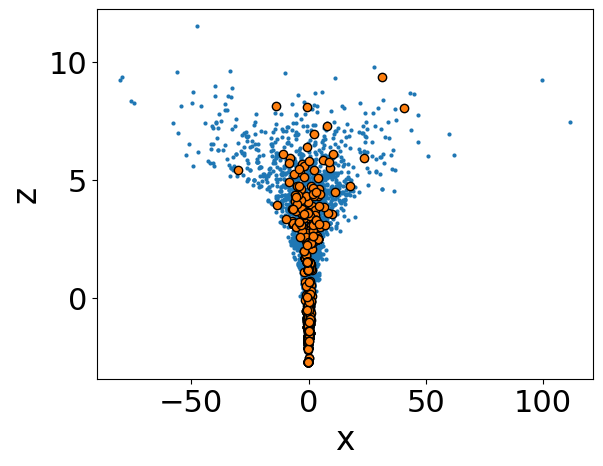

In [12]:
az.plot_pair(
    idata,
    var_names=["x", "z"],
    divergences=True,
    textsize=22,
);

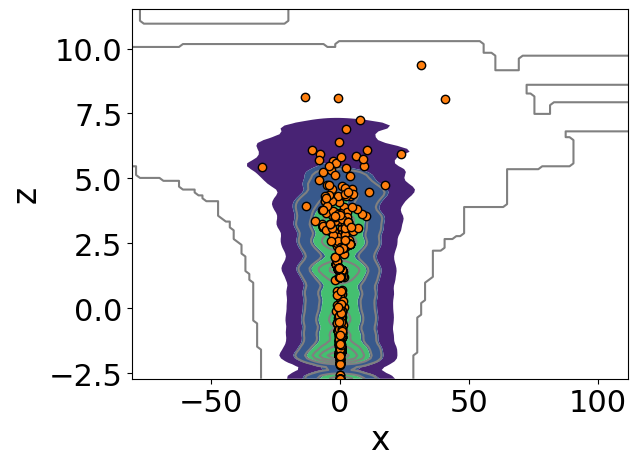

In [13]:
az.plot_pair(
    idata,
    var_names=["x", "z"],
    kind="kde",
    divergences=True,
    textsize=22,
);